In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10,6)

df = pd.read_csv('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')



# Fixing TotalCharge issue

In [116]:

problematic = df[df['TotalCharges'].str.strip() == '']
print(f"Number of problematic rows: {len(problematic)}")
print(problematic[["customerID","SeniorCitizen","tenure", "PhoneService", "MultipleLines","InternetService","OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV", "StreamingMovies", "MonthlyCharges", "TotalCharges"]])


Number of problematic rows: 11
      customerID  SeniorCitizen  tenure PhoneService     MultipleLines  \
488   4472-LVYGI              0       0           No  No phone service   
753   3115-CZMZD              0       0          Yes                No   
936   5709-LVOEQ              0       0          Yes                No   
1082  4367-NUYAO              0       0          Yes               Yes   
1340  1371-DWPAZ              0       0           No  No phone service   
3331  7644-OMVMY              0       0          Yes                No   
3826  3213-VVOLG              0       0          Yes               Yes   
4380  2520-SGTTA              0       0          Yes                No   
5218  2923-ARZLG              0       0          Yes                No   
6670  4075-WKNIU              0       0          Yes               Yes   
6754  2775-SEFEE              0       0          Yes               Yes   

     InternetService       OnlineSecurity         OnlineBackup  \
488           

It appears that all customers that have tenure = 0 have an empty string in TotalCharges. That's probably becuase they haven't been billed yet.


I could just fill them with 0's or with their monthly charges, but it's only 11 rows out of 7043 so I might aswell just drop them.

In [117]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna(subset=["TotalCharges"])

print(f"{len(df)} rows remaining.")


7032 rows remaining.


In [118]:
#Quick check after fixing
print(df['TotalCharges'].dtype)
print(df['TotalCharges'].isnull().sum())

float64
0


TotalCharge seems to be fixed.

# Explore fixed numerical data

In [119]:
q3 = df["tenure"].quantile(0.75)
q2 = df["tenure"].quantile(0.5)

high_tenure = df[df["tenure"] > q3]
low_tenure = df[df["tenure"] <= q2]

high_tenure_count = high_tenure["Churn"].value_counts()
low_tenure_count = low_tenure["Churn"].value_counts()

print(high_tenure_count)
print(low_tenure_count)


q3 = df["TotalCharges"].quantile(0.75)
q2 = df["TotalCharges"].quantile(0.5)

high_total_charges = df[df["TotalCharges"] > q3]
low_total_charges= df[df["TotalCharges"] <= q2]

high_total_charges_count = high_total_charges["Churn"].value_counts()
low_total_charges_count = low_total_charges["Churn"].value_counts()

print(high_total_charges_count)
print(low_total_charges_count)

df["tenure"].corr(df["TotalCharges"]) #0.825 correlation


Churn
No     1619
Yes     136
Name: count, dtype: int64
Churn
No     2149
Yes    1409
Name: count, dtype: int64
Churn
No     1503
Yes     255
Name: count, dtype: int64
Churn
No     2307
Yes    1209
Name: count, dtype: int64


np.float64(0.8258804609332021)

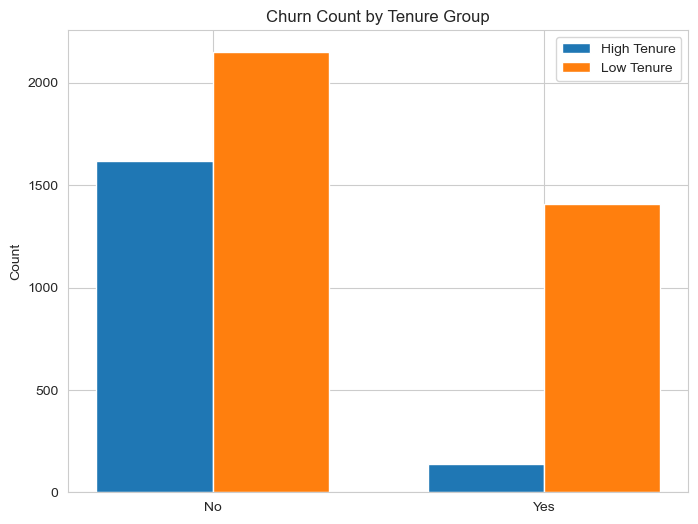

In [120]:
labels = high_tenure_count.index 
x = np.arange(len(labels))        
width = 0.35                      

fig, ax = plt.subplots(figsize=(8, 6))

rects1 = ax.bar(x - width/2, high_tenure_count, width, label='High Tenure')
rects2 = ax.bar(x + width/2, low_tenure_count, width, label='Low Tenure')

ax.set_ylabel('Count')
ax.set_title('Churn Count by Tenure Group')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

We can notice that customers that stuck for longer with the company are significantly less likely to churn.
Same can be said for total charges, the more of them, the more likely that the customer doesn't churn.


**However, we can notice a very strong correlation between these two features.**

# Features to consider
- Contract (!!!) [Ordinal]
- Tenure [Numerical]
- PaperlessBilling [Nominal]
- PaymentMethod [Nominal]
- InternetService [Nominal]
- OnlineSecurity [Nominal]
- TechSupport [Nominal]
- Dependents (?) [Nominal]
- Partner (?) [Nominal]


# Map strings to numbers and scale


In [121]:
#we know Contract is a ordinal feature, so I will map it 0-2

contract_map = {'Month-to-month' : 0, 'One year' : 1, 'Two year' : 2}

df['Contract'] = df['Contract'].map(contract_map)

#paperless billing is binary feature so I map it 0/1

binary_map = {'Yes' : 1, 'No' : 0}

df['PaperlessBilling'] = df['PaperlessBilling'].map(binary_map)

#same for dependents and partner

df['Partner'] = df['Partner'].map(binary_map)

df['Dependents'] = df['Dependents'].map(binary_map)

#from data exploration: electronic check has 45% churn vs 15-19% for other methods
#payment method is a nominal feature so I will have to create separate feature for Electronic check and map it as a binary feature
df["ElectronicCheck"] = 0
df.loc[df["PaymentMethod"] == "Electronic check", "ElectronicCheck"] = 1
df.loc[df["PaymentMethod"] != "Electronic check", "ElectronicCheck"] = 0

#from data exploration: Fiber optic has 41% churn vs 19% for DSL and 7% for no internet service
#similiarly for InternetService feature, we are interested in Fiber optic internet so we map it as a binary feature
df["FiberOptic"] = 0
df.loc[df["InternetService"] == "Fiber optic", "FiberOptic"] = 1
df.loc[df["InternetService"] != "Fiber optic", "FiberOptic"] = 0 

#for OnlineSecurity and TechSupport features, they only come with InternetService, so the values are "No internet service" "No" "Yes",
# where "No" means that somebody has an internet service but they did not choose the feature. These are also the cases im interested with.
#from data exploration: customers with internet but no security or no tech support have significantly higher churn
#Therefore, Im gonna map them as a sepearate features: "InternetServiceButNoOnlineSecurity" and "InternetServiceButNoTechSupport"

df["InternetServiceButNoOnlineSecurity"] = 0
df.loc[df["OnlineSecurity"] == "No", "InternetServiceButNoOnlineSecurity"] = 1
df.loc[df["OnlineSecurity"] != "No", "InternetServiceButNoOnlineSecurity"] = 0

df["InternetServiceButNoTechSupport"] = 0
df.loc[df["TechSupport"] == "No", "InternetServiceButNoTechSupport"] = 1
df.loc[df["TechSupport"] != "No", "InternetServiceButNoTechSupport"] = 0

#for numerical data, I will have to scale it later on (Notebook 03), after splitting the data in order to prevent data leakage.

#Now I also have to map churn

df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})





Now that data is prepared, I will create a new data frame to separate the features that I'm interested in from the rest and I will save it to a csv file.

In [122]:
model_data = df[[
    # Numerical features
    'tenure', 'TotalCharges',
    
    # Binary features created
    'ElectronicCheck', 'FiberOptic', 
    'InternetServiceButNoOnlineSecurity', 'InternetServiceButNoTechSupport',
    
    # Binary features mapped
    'Partner', 'Dependents', 'PaperlessBilling',
    
    # Ordinal
    'Contract',
    
    # Target
    'Churn'
]].copy()

model_data.head(16)

#Saving data
model_data.to_csv('../data/model_ready_data.csv', index= False)

# Data Preprocessing Summary

## Data Quality Fixes
- **TotalCharges**: Converted from object to numeric, dropped empty strings.

## Feature Engineering

**Ordinal Features**:
- `Contract`: Month-to-month=0, One year=1, Two year=2

**Binary Features** (Yes/No -> 1/0):
- Partner, Dependents, PaperlessBilling

**Risk-Based Features** (from EDA insights):
- `ElectronicCheck`: 45% churn vs 15-19% for other payment methods
- `FiberOptic`: 41% churn vs 19% DSL
- `InternetServiceButNoOnlineSecurity`: Higher churn without security
- `InternetServiceButNoTechSupport`: Higher churn without support

**Target Variable**:
- `Churn`: Yes=1, No=0

## Final Dataset
- **Shape**: (7032 rows, 11 columns)
- **Features**: 10 predictive features + 1 target
- **Quality**: No missing values, all numeric, no duplicates
- **Saved**: `model_ready_data.csv`

## To-Do
- Train/test split
- Scale numerical features
- Train baseline models 
- Evaluate and compare performance